<a href="https://colab.research.google.com/github/abunchoftigers/Prediction-of-Product-Sales/blob/main/Prediction_of_Product_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Product Sales

- Author David Dyer


## Project Overview

In [1]:
from google.colab import drive
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


## Load and Inspect Data

In [3]:
fpath = '/content/drive/MyDrive/Coding Dojo - Data Science/Week 2/Data/sales_predictions_2023.csv'
df = pd.read_csv(fpath)

In [4]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## Clean Data

First let's learn some things about our data.

In [6]:
print(f'{df.shape[0]} rows\n{df.shape[1]} columns')

8523 rows
12 columns


In [7]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [8]:
df.duplicated().value_counts(), df.duplicated().sum() # Hooray no duplicates!

(False    8523
 dtype: int64,
 0)

In [9]:
pd.isna(df).sum() # Some weights and outlet sizes are missing

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

We'll replace missing string types with 'MISSING', and missing numeric types with -1.

In [10]:
# Check the dtype of every column
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [11]:
df.select_dtypes('object') # Placeholder 'MISSING' looks ok for Outlet_Size

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2
2,FDN15,Low Fat,Meat,OUT049,Medium,Tier 1,Supermarket Type1
3,FDX07,Regular,Fruits and Vegetables,OUT010,NaN,Tier 3,Grocery Store
4,NCD19,Low Fat,Household,OUT013,High,Tier 3,Supermarket Type1
...,...,...,...,...,...,...,...
8518,FDF22,Low Fat,Snack Foods,OUT013,High,Tier 3,Supermarket Type1
8519,FDS36,Regular,Baking Goods,OUT045,NaN,Tier 2,Supermarket Type1
8520,NCJ29,Low Fat,Health and Hygiene,OUT035,Small,Tier 2,Supermarket Type1
8521,FDN46,Regular,Snack Foods,OUT018,Medium,Tier 3,Supermarket Type2


In [12]:
# Fill in missing string values
obj_cols = df.select_dtypes(include='object').columns
df[obj_cols] = df[obj_cols].fillna(value='MISSING')
# Fill in missing numeric values
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].fillna(value=-1)

In [13]:
# Are there still nulls?
pd.isna(df).sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

Now let's find and fix any inconsistent categories.

In [14]:
string_cols = df.select_dtypes('object').columns
string_cols
line_break = "\n"

for col in string_cols:
  print(f'Value Counts for {col}: ')
  print(df[col].value_counts())
  print('\n')

Value Counts for Item_Identifier: 
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


Value Counts for Item_Fat_Content: 
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Value Counts for Item_Type: 
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Value Counts for Outlet_Identifier: 
OUT027    935
OUT013    932
OUT049    930
OUT046

Item_Fat_Content can use some cleaning. First, we'll create a map of the inconsistently formatted values to the correctly formatted values.

In [15]:
item_fat_map = {
    'LF': 'Low Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular'
}

Now we update our data frame with the cleaned values

In [16]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(item_fat_map)

In [17]:
# Make sure it worked
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

Let's take a look at some statistical summaries for each numeric column.

In [18]:
for col in df[num_cols]:
  print(f'{col:} {line_break} Lowest:  {df[col].min()}{line_break} Highest: {df[col].max()}{line_break} Mean:    {df[col].mean()}{line_break}')

Item_Weight 
 Lowest:  -1.0
 Highest: 21.35
 Mean:    10.478936407368296

Item_Visibility 
 Lowest:  0.0
 Highest: 0.328390948
 Mean:    0.06613202877895108

Item_MRP 
 Lowest:  31.29
 Highest: 266.8884
 Mean:    140.9927819781767

Outlet_Establishment_Year 
 Lowest:  1985
 Highest: 2009
 Mean:    1997.8318667135984

Item_Outlet_Sales 
 Lowest:  33.29
 Highest: 13086.9648
 Mean:    2181.288913575032



## Exploratory Data Analysis

# Histograms for numeric data

In [19]:
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

## Item_Weight

<Axes: xlabel='Item_Weight', ylabel='Count'>

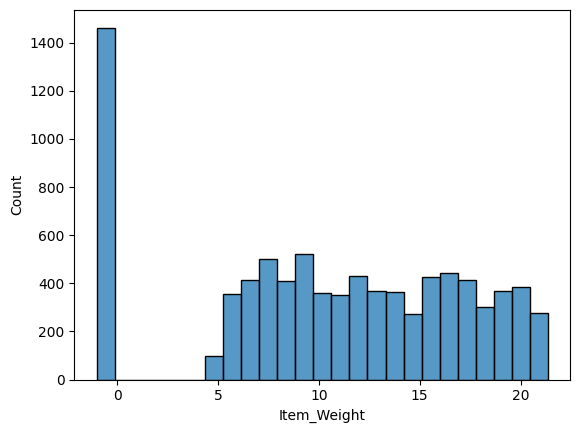

In [20]:
sns.histplot(data=df, x='Item_Weight')

<Axes: xlabel='Item_Visibility', ylabel='Count'>

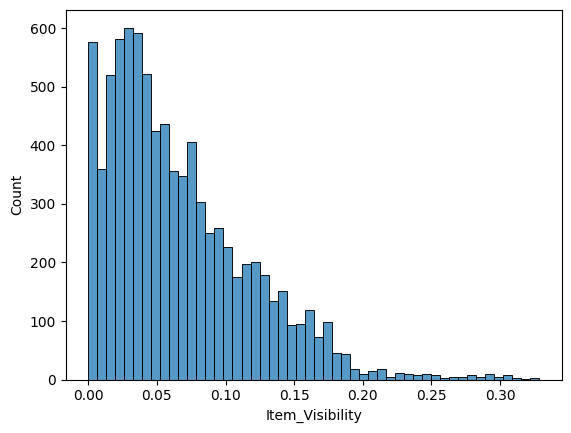

In [21]:
sns.histplot(data=df, x='Item_Visibility')

## Item_MRP

<Axes: xlabel='Item_MRP', ylabel='Count'>

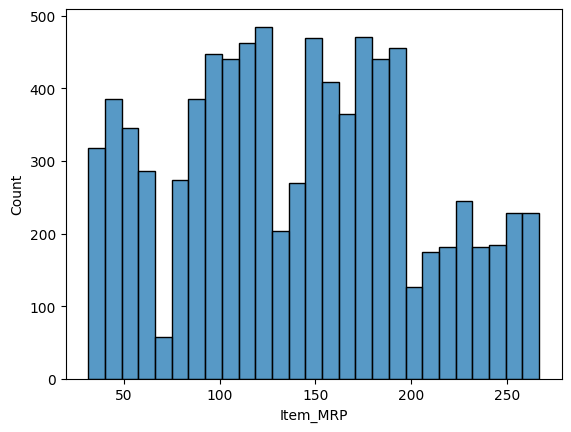

In [22]:
sns.histplot(data=df, x='Item_MRP')

## Outlet_Establishment_Year

<Axes: xlabel='Outlet_Establishment_Year', ylabel='Count'>

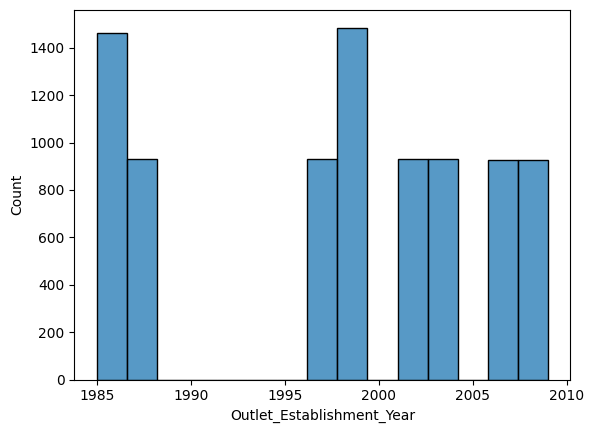

In [23]:
sns.histplot(data=df, x='Outlet_Establishment_Year')

## Item_Outlet_Sales

<Axes: xlabel='Item_Outlet_Sales', ylabel='Count'>

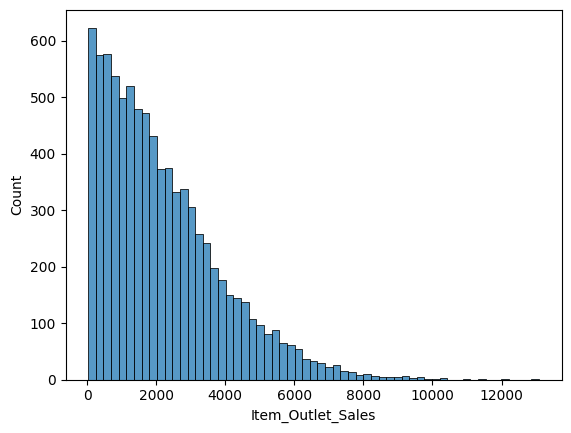

In [24]:
sns.histplot(data=df, x='Item_Outlet_Sales')

# Boxplots: View statistical summaries of numerical features

In [25]:
df.set_index('Item_Identifier')

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
Item_Identifier,,,,,,,,,,,
FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,MISSING,Tier 3,Grocery Store,732.3800
NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...
FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,MISSING,Tier 2,Supermarket Type1,549.2850
NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136


## Item_Weight
sns.boxplot(data=df, x='Item_Weight')

<Axes: xlabel='Item_Weight'>

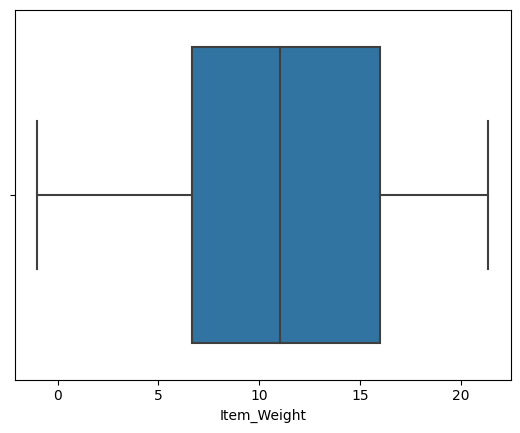

In [26]:
sns.boxplot(data=df, x='Item_Weight')

## Item_Visibility

<Axes: xlabel='Item_Weight'>

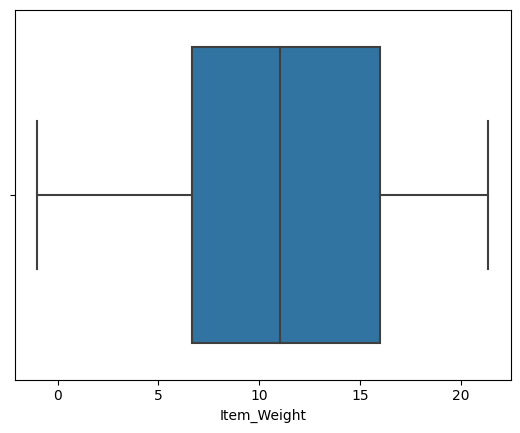

In [27]:
sns.boxplot(data=df, x='Item_Weight')

## Item_MRP

In [ ]:
sns.boxplot(data=df, x='Item_MRP')

<Axes: xlabel='Item_MRP'>

## Outlet_Establishment_Year

In [ ]:
sns.boxplot(data=df, x='Outlet_Establishment_Year')

## Item_Outlet_Sales

In [ ]:
sns.boxplot(data=df, x='Item_Outlet_Sales')

## Countplots: Frequencies of Catagorical Features

In [ ]:
# Countplots
sns.countplot(data=df, x='Item_Identifier')

In [ ]:
# Heatmaps
obj_cols

## Heatmaps: Corellations

In [ ]:
sns.heatmap(data=df, x='Outlet_Establishment_Year', y='Item_MRP')